# Vascular age - example

## Setup

### Import libraries

In [5]:
! pip install wfdb
! pip install neurokit2

In [2]:
import neurokit2 as nk2
import wfdb

In [136]:
import numpy as np
from scipy import signal
from statistics import median
import matplotlib.pyplot as plt

### Setup database

In [8]:
# Specify the database
database_name = 'pulse-transit-time-ppg/1.1.0' # The name of the database on Physionet

# Find a list of records in the database
record_list = wfdb.get_record_list(database_name)

# Output the result
print(f"The '{database_name}' database contains {len(record_list)} records")

The 'pulse-transit-time-ppg/1.1.0' database contains 66 records


### Import required functions

- Finding suitable records in the database

In [170]:
def find_suitable_records(required_signals, required_duration, required_activity, do_verbose=False):
    """
    Description: Finds suitable records in the Pulse Transit Time PPG dataset.
    """    
    
    matching_recs = {'dir':[], 'name':[], 'length':[], 'start_sbp':[], 'end_sbp':[], 'delta_sbp':[], 'age':[]}

    for record in record_list:
        if do_verbose:
            print('Record: {}'.format(record), end="", flush=True)
    
        # check whether this record corresponds to a suitable activity
        if not required_activity in record:
            if do_verbose:
                print('   (not required activity)')
            continue

        record_data = wfdb.rdheader(record,
                                    pn_dir=database_name,
                                    rd_segments=True)

        # Check whether the required signals are present in the record
        sigs_present = record_data.sig_name
        if not all(x in sigs_present for x in required_signals):
            if do_verbose:
                print('   (missing signals)')
            continue

        seg_length = record_data.sig_len/(record_data.fs)

        if seg_length < required_duration:
            if do_verbose:
                print(f' (too short at {seg_length/60:.1f} mins)')
            continue
    
        # This record does meet the requirements, so extract information and data from it
    
        # Information
        matching_recs['dir'].append(database_name)
        matching_recs['name'].append(record_data.record_name)
        matching_recs['length'].append(seg_length)
    
        # Blood pressure measurements
        str_to_find = '<bp_sys_start>: '
        curr_len = len(str_to_find)
        start_el = record_data.comments[0].index(str_to_find) + curr_len
        str_to_find = '<bp_sys_end>'
        end_el = record_data.comments[0].index(str_to_find) - 1
        matching_recs['start_sbp'].append(int(record_data.comments[0][start_el:end_el]))
        str_to_find = '<bp_sys_end>: '
        curr_len = len(str_to_find)
        start_el = record_data.comments[0].index(str_to_find) + curr_len
        str_to_find = '<bp_dia_start>'
        end_el = record_data.comments[0].index(str_to_find) - 1
        matching_recs['end_sbp'].append(int(record_data.comments[0][start_el:end_el]))
        matching_recs['delta_sbp'].append(matching_recs['end_sbp'][-1]-matching_recs['start_sbp'][-1])

        # ages
        str_to_find = '<age>: '
        curr_len = len(str_to_find)
        start_el = record_data.comments[0].index(str_to_find) + curr_len
        str_to_find = '<bp_sys_start>'
        end_el = record_data.comments[0].index(str_to_find) - 1
        matching_recs['age'].append(float(record_data.comments[0][start_el:end_el]))

        if do_verbose:
            print('   (met requirements)')
    
    if do_verbose:
        print(f"A total of {len(matching_recs['dir'])} out of {len(record_list)} records met the requirements.")
    
    return matching_recs

- Extracting a segment of data from a record

In [54]:
def extract_segment_of_data(start_seconds, n_seconds_to_load, record_name, record_dir, required_signals, do_verbose=False):

    # Get sampling frequency from header data
    record_data = wfdb.rdheader(record_name,
                                pn_dir=record_dir,
                                rd_segments=True)
    fs = record_data.fs
    
    # Specify timings of segment to be extracted
    sampfrom = fs * start_seconds
    sampto = fs * (start_seconds + n_seconds_to_load)

    # Load segment data
    segment_data = wfdb.rdrecord(record_name=record_name,
                                 channel_names = required_signals,
                                 sampfrom=sampfrom,
                                 sampto=sampto,
                                 pn_dir=record_dir)

    if do_verbose:
        print(f"{n_seconds_to_load} seconds of data extracted from record: {record_name}")
    
    return segment_data

- Find peaks in PPG signal

In [73]:
def get_ppg_peaks(raw, fs):
  ppg_clean = nk2.ppg_clean(raw, sampling_rate=fs)
  peaks = nk2.ppg_findpeaks(ppg_clean, method="elgendi", show=False)  
  return peaks['PPG_Peaks']

- Find peaks in ECG signal

In [104]:
def get_ecg_peaks(raw, fs):
    ecg_clean = nk2.ecg_clean(raw, sampling_rate=fs)
    signals, info = nk2.ecg_peaks(ecg_clean, method="neurokit", show=False)  
    peaks = info["ECG_R_Peaks"]
    return peaks

- Find PPG pulse onsets

In [109]:
def get_ppg_onsets(ppg, pks, fs):
    ons = np.empty(0)
    for i in range(len(pks) - 1):
        start = pks[i]
        stop = pks[i + 1]
        ibi = ppg[start:stop]
        aux_ons = np.argmin(ibi)
        # aux_ons, = np.where(ibi == np.min(ibi))
        ind_ons = aux_ons.astype(int)
        ons = np.append(ons, ind_ons + start)   

    ons = ons.astype(int)
    return ons

- A function to find the index in a list which immediately follows a specified point

In [116]:
def find_next(array, value):
    array = np.asarray(array)
    diffs = array - value
    diffs = np.where(diffs>0, diffs, 100000)
    idx = diffs.argmin()
    return array[idx]

# Extracting a dataset

## Finding suitable records in the database

In [171]:
# specify requirements
name_of_ecg_signal = "ecg"
name_of_ppg_signal = "pleth_1"
required_signals = [name_of_ecg_signal, name_of_ppg_signal]
required_duration = 1*60 # in seconds
required_activity = "sit"

# find records which meet these requirements
do_verbose = True
matching_recs = find_suitable_records(required_signals, required_duration, required_activity, do_verbose)

Record: s1_walk   (not required activity)
Record: s1_run   (not required activity)
Record: s1_sit   (met requirements)
Record: s2_walk   (not required activity)
Record: s2_run   (not required activity)
Record: s2_sit   (met requirements)
Record: s3_sit   (met requirements)
Record: s3_walk   (not required activity)
Record: s3_run   (not required activity)
Record: s4_sit   (met requirements)
Record: s4_run   (not required activity)
Record: s4_walk   (not required activity)
Record: s5_walk   (not required activity)
Record: s5_run   (not required activity)
Record: s5_sit   (met requirements)
Record: s6_run   (not required activity)
Record: s6_sit   (met requirements)
Record: s6_walk   (not required activity)
Record: s7_walk   (not required activity)
Record: s7_run   (not required activity)
Record: s7_sit   (met requirements)
Record: s8_sit   (met requirements)
Record: s8_run   (not required activity)
Record: s8_walk   (not required activity)
Record: s9_walk   (not required activity)
Record

## Extract data from a record

In [53]:
# specify details of data to be extracted
start_seconds = 0
n_seconds_to_load = 60
record_name = matching_recs['name'][0]
record_dir = matching_recs['dir'][0]

# extract these data
do_verbose = True
segment_data = extract_segment_of_data(start_seconds, n_seconds_to_load, record_name, record_dir, required_signals, do_verbose)

60 seconds of data extracted from segment: s1_sit


# Signal processing

## Extract signals

- Extract PPG and ECG signals

In [67]:
sig_list = ["ppg", "ecg"]
for sig in sig_list:
    exec("curr_sig_name = name_of_" + sig + "_signal")
    rel_col = segment_data.sig_name.index(curr_sig_name)
    exec(sig + " = segment_data.p_signal[:,rel_col]")

- Extract sampling frequency

In [81]:
fs = segment_data.fs

## Invert PPG signal

In [78]:
ppg = -1*ppg

## Filter signals

- Filter PPG

In [82]:
ppg = nk2.ppg_clean(ppg, sampling_rate=fs)

- Filter ECG

In [86]:
ecg = nk2.ecg_clean(ecg, sampling_rate=fs)

## Beat detection

### PPG beat detection

- Detect beats

In [92]:
ppg_peaks = get_ppg_peaks(ppg, fs)

- Plot results

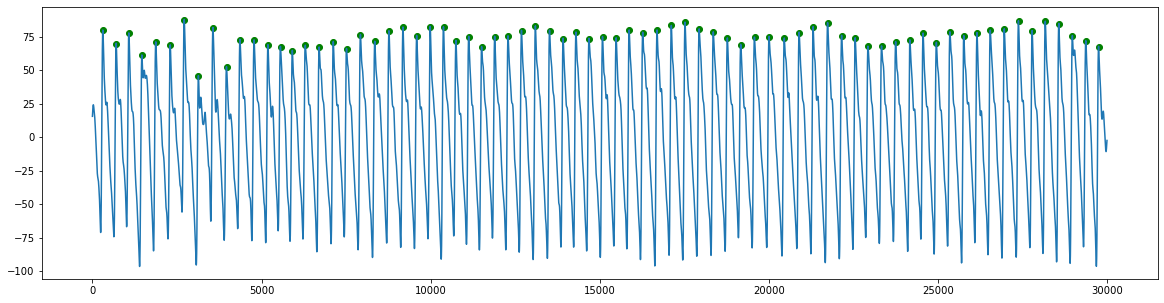

In [84]:
plt.figure(figsize=(20,5))
plt.plot(ppg)
heights = ppg[ppg_peaks]
plt.scatter(ppg_peaks, heights, marker='o', color='green')

### ECG beat detection

- Detect beats

In [106]:
ecg_peaks = get_ecg_peaks(ecg, fs)

- Plot results

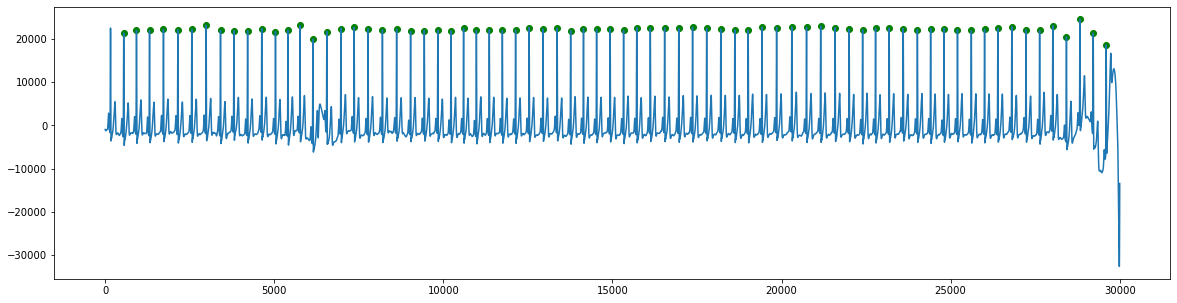

In [107]:
plt.figure(figsize=(20,5))
plt.plot(ecg)
heights = ecg[ecg_peaks]
plt.scatter(ecg_peaks, heights, marker='o', color='green')

## Extract timings

### ECG timings

The ECG timings are simply the times of the R-waves, which indicate the times of ventricular depolarisation (i.e. the electrical activity which prompts ventricular contraction).

In [108]:
ecg_timings = ecg_peaks

### PPG timings

Ideally, we wouldn't use the times of systolic peaks on PPG waves, because there can be a variable delay between the pulse onset and systolic peak. Therefore, we use an alternative, such as the time of pulse onset:

- Getting the times of PPG pulse wave onsets

In [114]:
ppg_timings = get_ppg_onsets(ppg,ppg_peaks,fs)

- Plotting the results

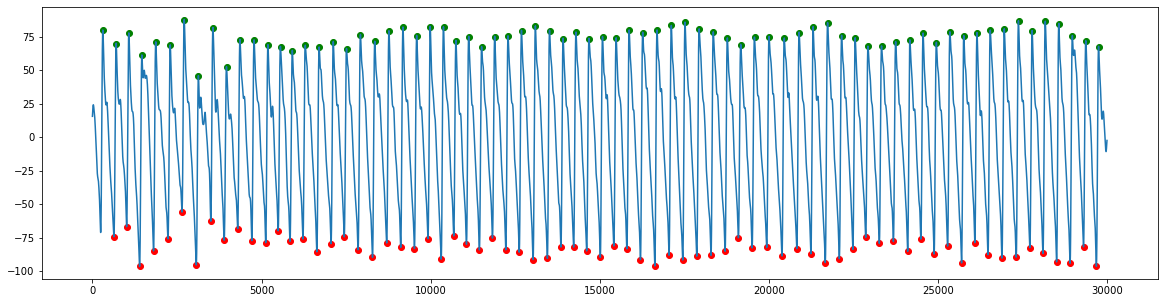

In [115]:
plt.figure(figsize=(20,5))
plt.plot(ppg)
heights_peaks = ppg[ppg_peaks]
heights_onsets = ppg[ppg_timings]
plt.scatter(ppg_peaks, heights_peaks, marker='o', color='green')
plt.scatter(ppg_timings, heights_onsets, marker='o', color='red')

## Extract pulse arrival times

- Find pairs of R-waves and subsequent PPG pulse onsets

In [119]:
rel_ppg_timings = []
for ecg_timing in ecg_timings:
    current_ppg_timing = find_next(ppg_timings, ecg_timing)
    rel_ppg_timings.append(current_ppg_timing)

- Calculate pulse arrival times as the difference between the times of R-waves and subsequent PPG pulse onsets

In [134]:
pats = (rel_ppg_timings - ecg_timings)/fs

# Modelling

## Extract dataset

Extract a dataset of:
- Parameter(s) derived from PPG and ECG signals: pulse arrival time
- Reference parameter(s): age

### Setup:

In [162]:
subj_nos = [i for i in range(len(matching_recs['name']))]

### Extract median pulse arrival times

In [163]:
median_pats = []
for subj_no in subj_nos:

    # specify this subject's record name and directory:
    record_name = matching_recs['name'][subj_no]
    record_dir = matching_recs['dir'][subj_no]

    # extract this subject's signals
    segment_data = extract_segment_of_data(start_seconds, n_seconds_to_load, record_name, record_dir, required_signals)
    fs = segment_data.fs
    sig_list = ["ppg", "ecg"]
    for sig in sig_list:
        exec("curr_sig_name = name_of_" + sig + "_signal")
        rel_col = segment_data.sig_name.index(curr_sig_name)
        exec(sig + " = segment_data.p_signal[:,rel_col]")
        
    # invert PPG signal
    ppg = -1*ppg
    
    # filter signals
    ppg = nk2.ppg_clean(ppg, sampling_rate=fs)
    ecg = nk2.ecg_clean(ecg, sampling_rate=fs)
    
    # detect beats in signals
    ecg_peaks = get_ecg_peaks(ecg, fs)
    ppg_peaks = get_ppg_peaks(ppg, fs)
    
    # obtain timings
    ecg_timings = ecg_peaks
    ppg_timings = get_ppg_onsets(ppg,ppg_peaks,fs)
    
    # extract pulse arrival times
    rel_ppg_timings = []
    for ecg_timing in ecg_timings:
        current_ppg_timing = find_next(ppg_timings, ecg_timing)
        rel_ppg_timings.append(current_ppg_timing)
    pats = (rel_ppg_timings - ecg_timings)/fs
    
    # find median pulse arrival time for this subject
    curr_median_pat = median(pats)
    median_pats.append(curr_median_pat)
    
    print(f"Subject no. {subj_no} has median PAT of {median_pats[subj_no]} seconds")

Subject no. 0 has median PAT of 0.172 seconds
Subject no. 1 has median PAT of 0.658 seconds
Subject no. 2 has median PAT of 0.192 seconds
Subject no. 3 has median PAT of 0.162 seconds
Subject no. 4 has median PAT of 0.152 seconds
Subject no. 5 has median PAT of 0.192 seconds
Subject no. 6 has median PAT of 0.15 seconds
Subject no. 7 has median PAT of 0.154 seconds
Subject no. 8 has median PAT of 0.208 seconds
Subject no. 9 has median PAT of 0.18 seconds
Subject no. 10 has median PAT of 0.222 seconds
Subject no. 11 has median PAT of 0.176 seconds
Subject no. 12 has median PAT of 0.154 seconds
Subject no. 13 has median PAT of 0.168 seconds
Subject no. 14 has median PAT of 0.214 seconds
Subject no. 15 has median PAT of 0.184 seconds
Subject no. 16 has median PAT of 0.204 seconds
Subject no. 17 has median PAT of 0.18 seconds
Subject no. 18 has median PAT of 0.17 seconds
Subject no. 19 has median PAT of 0.184 seconds
Subject no. 20 has median PAT of 0.176 seconds
Subject no. 21 has median P

### Extract ages

In [173]:
ages = []
for subj_no in subj_nos:

    # specify this subject's record name and directory:
    record_name = matching_recs['name'][subj_no]
    record_dir = matching_recs['dir'][subj_no]

    # extract this subject's age
    curr_age = matching_recs['age'][subj_no]
    ages.append(curr_age)

## Inspect dataset

In [179]:
print()

[-0.07084778 -0.05667823 -0.07084778 -0.07084778 -0.07084778 -0.0991869
 -0.08501734 -0.14169557 -0.05667823 -0.07084778 -0.08501734 -0.07084778
 -0.07084778 -0.15586513 -0.05667823 -0.08501734 -0.05667823 -0.0991869
 -0.07084778 -0.0991869  -0.07084778 -0.05667823]


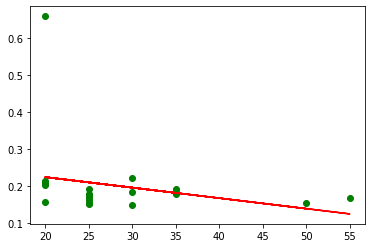

In [180]:
plt.scatter(ages, median_pats, marker='o', color='green')
m, b = np.polyfit(ages, median_pats, 1)
plt.plot(ages, m*np.array(ages)+b, color='red')

- if we exclude the outlier:

In [191]:
rel_ages = []
rel_median_pats = []
for el in range(len(ages)):
    if median_pats[el]<0.3:
        rel_ages.append(ages[el])
        rel_median_pats.append(median_pats[el])

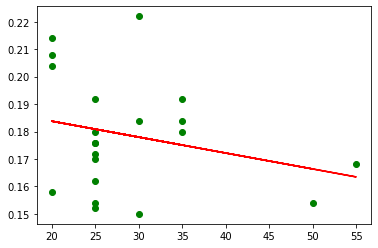

In [193]:
plt.scatter(rel_ages, rel_median_pats, marker='o', color='green')
m, b = np.polyfit(rel_ages, rel_median_pats, 1)
plt.plot(rel_ages, m*np.array(rel_ages)+b, color='red')

# Scratchpad

## Find Diastolic peak and Dicrotic notch

### Differentiation Demo

In [11]:
import scipy.signal as sp

Text(0, 0.5, '2nd derivative of PPG')

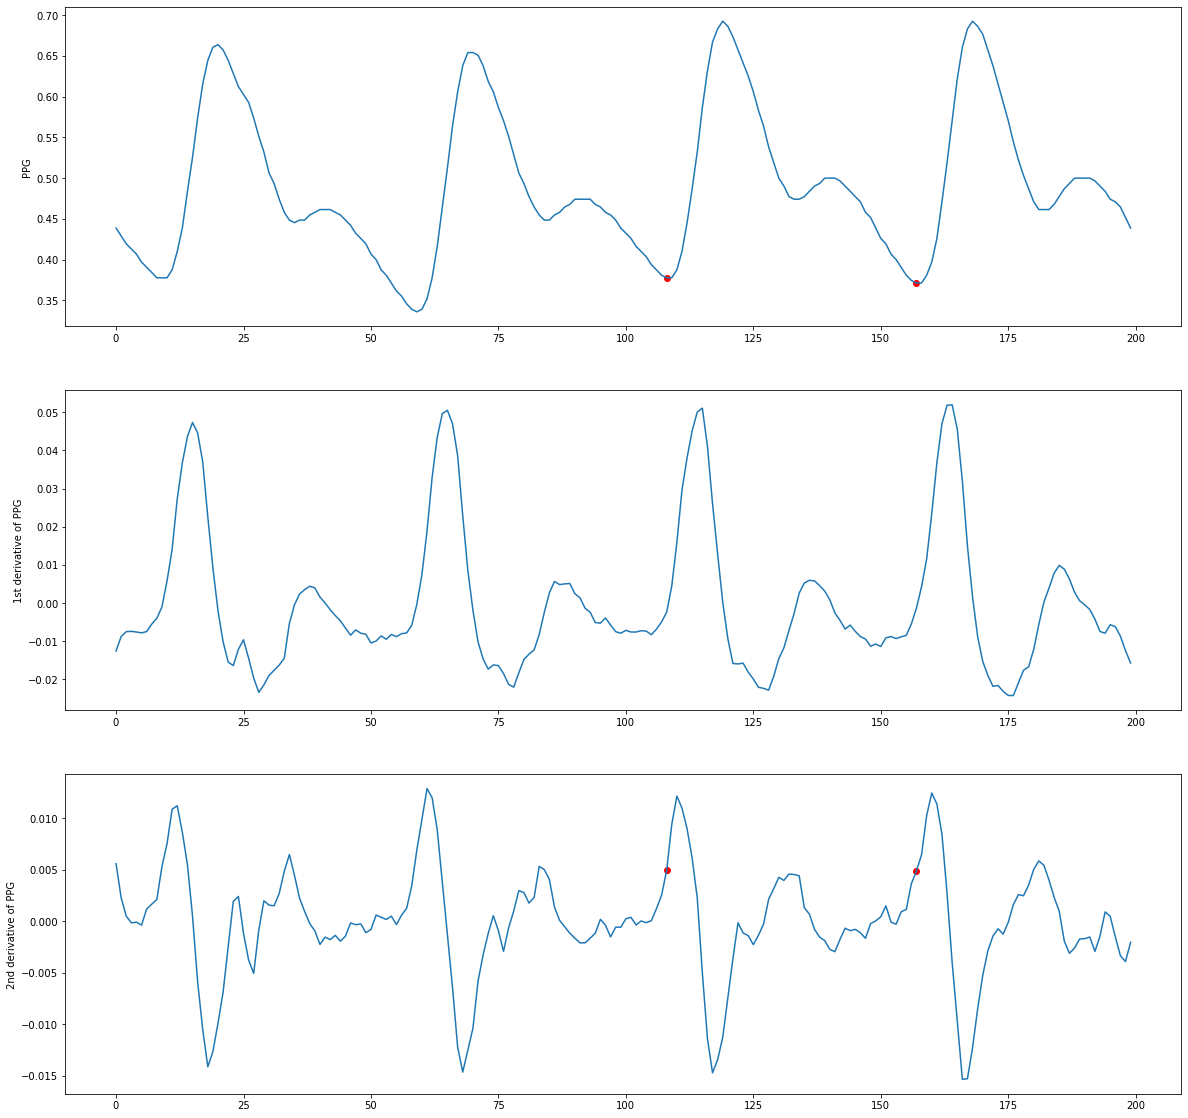

In [12]:
ppg_seg = ppg[0:200]
seg_peaks = get_peaks(ppg_seg, fs)
seg_onset = get_onsets(ppg_seg, seg_peaks, fs)
d1x = sp.savgol_filter(ppg_seg, 9, 5, deriv = 1) 
d2x = sp.savgol_filter(ppg_seg, 9, 5, deriv = 2) 
d3x = sp.savgol_filter(ppg_seg, 9, 5, deriv = 3) 
fig, axs = plt.subplots(3, figsize=(20,20))
axs[0].plot(ppg_seg)
axs[0].scatter(seg_onset, ppg_seg[seg_onset], color='red')
axs[0].set_ylabel('PPG')
axs[1].plot(d1x)
axs[1].set_ylabel('1st derivative of PPG')
axs[2].plot(d2x)
axs[2].scatter(seg_onset, d2x[seg_onset], color='red')
axs[2].set_ylabel('2nd derivative of PPG')

### Actual Function

In [13]:
import scipy.signal as sp

def get_dia_dic(ppg, pks, ons, fs):
    d1x = sp.savgol_filter(ppg, 9, 5, deriv = 1) 
    d2x = sp.savgol_filter(ppg, 9, 5, deriv = 2) 
    d3x = sp.savgol_filter(ppg, 9, 5, deriv = 3) 

    dia = np.empty(0)
    dic = np.empty(0)
    for i in range(len(ons) - 1):
        start = ons[i]
        stop = ons[i + 1]
        ind_pks = np.intersect1d(np.where(pks < stop), np.where(pks > start))
        if len(ind_pks) != 0:
            ind_pks = ind_pks[0]
            ind_pks = pks[ind_pks]
            ibi_portion = ppg[ind_pks:stop]
            ibi_2d_portion = d2x[ind_pks:stop]
           
            aux_dic, _ = sp.find_peaks(ibi_2d_portion)
            aux_dic = aux_dic.astype(int)
            aux_dia, _ = sp.find_peaks(-ibi_2d_portion)
            aux_dia = aux_dia.astype(int)   
            if len(aux_dic) != 0:
                ind_max, = np.where(ibi_2d_portion[aux_dic] == np.max(ibi_2d_portion[aux_dic]))
                aux_dic_max = aux_dic[ind_max]
                if len(aux_dia) != 0:
                    nearest = aux_dia - aux_dic_max
                    aux_dic = aux_dic_max
                    dic = np.append(dic, (aux_dic + ind_pks).astype(int))
                    
                    ind_dia, = np.where(nearest > 0)
                    aux_dia = aux_dia[ind_dia]
                    nearest = nearest[ind_dia]
                    if len(nearest) != 0:
                        ind_nearest, = np.where(nearest == np.min(nearest))
                        aux_dia = aux_dia[ind_nearest]
                        dia = np.append(dia, (aux_dia + ind_pks).astype(int))
                else:
                    dic = np.append(dic, (aux_dic_max + ind_pks).astype(int))
        
        break
    dia = dia.astype(int)
    dic = dic.astype(int)

    return dia, dic

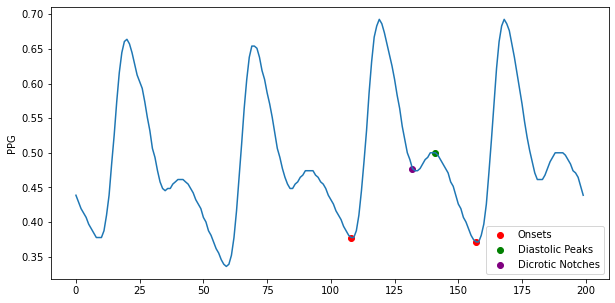

In [14]:
ppg_seg = ppg[0:200]
seg_peaks = get_peaks(ppg_seg, fs)
seg_onset = get_onsets(ppg_seg, seg_peaks, fs)
seg_dia, seg_dic = get_dia_dic(ppg_seg, seg_peaks, seg_onset, fs)
plt.figure(figsize=(10,5))
plt.plot(ppg_seg)
plt.ylabel('PPG')
plt.scatter(seg_onset, ppg_seg[seg_onset], color='red',label='Onsets')
plt.scatter(seg_dia, ppg_seg[seg_dia], color='green',label='Diastolic Peaks')
plt.scatter(seg_dic, ppg_seg[seg_dic], color='purple',label='Dicrotic Notches')
plt.legend()

## Run BP Estimation

In [15]:
def get_fids(ppg, fs):
  pks = get_peaks(ppg, fs)
  ons = get_onsets(ppg, pks, fs)
  dia, dic = get_dia_dic(ppg, pks, ons, fs)
  return pks, ons, dia, dic

In [16]:
def get_signal(rel_segment_no, label, start_sec, len_sec):
  if label == 'ppg':
    chan = 'Pleth'
  elif label == 'bp':
    chan = 'ABP'
  rel_segment_name = segment_names[rel_segment_no]
  rel_segment_dir = segment_dirs[rel_segment_no]

  sig, meta = wfdb.rdsamp(record_name=rel_segment_name, 
                            pn_dir=rel_segment_dir, 
                            sampfrom=0, sampto=100)
  fs = round(meta['fs'])

  sampfrom = fs*start_sec
  sampto = fs*(start_sec + len_sec)

  req_sig, fields = wfdb.rdsamp(record_name=rel_segment_name, 
                            pn_dir=rel_segment_dir, 
                            sampfrom=sampfrom, sampto=sampto, 
                            channel_names = [chan]) 
  req_sig = req_sig.squeeze()

  return req_sig, fs

In [17]:
def get_less_closest(array, value):
  array = np.array(array)
  index, arr = np.argwhere(array<value), array[array<value]
  idx = (np.abs(arr - value)).argmin()
  return array[index[idx]]

In [18]:
def remove_nan(sig):
    nan_ind= np.argwhere(np.isnan(sig)) 
    return np.delete(sig, nan_ind)

#### Test Example

In [19]:
dias = [467,505,617,679,747,825,923,982,1065,1147,1225,1302,1378,1460,1540,1616,1703,1776,1853,1933,2010,2096,2179,2250,2331,2407,2487,2563,2642,2716,2800,2875,2961,3031,3111,3190,3292,3342,3418,3496,3576]
pks = [326,407,487,568,648,728,809,889,968,1047,1127,1206,1285,1363,1443,1521,1601,1680,1758,1838,1917,1996,2075,2154,2233,2312,2390,2469,2547,2625,2704,2781,2860,2938,3016,3093,3170,3247,3326,3404,3482,3559,3636]

peaks = [get_less_closest(pks, dia)[0] for dia in dias]
delta_t = np.subtract(peaks, dias)

delta_t

array([-60, -18, -49, -31, -19, -16, -34, -14, -18, -20, -19, -17, -15,
       -17, -19, -15, -23, -18, -15, -16, -14, -21, -25, -17, -19, -17,
       -18, -16, -17, -12, -19, -15, -23, -15, -18, -20, -45, -16, -14,
       -14, -17])

### Get delta_t and bp example

In [20]:
ppg, fs = get_signal(3, 'ppg', 100, 60)
ppg = remove_nan(ppg)
pks, ons, dias, dics = get_fids(ppg, fs)

In [21]:
corrs_peaks = [get_less_closest(pks, dia)[0] for dia in dias]
delta_t = np.subtract(dias, corrs_peaks)/fs

In [22]:
bp, fs = get_signal(3, 'bp', 100, 60)
bp = remove_nan(bp)
pks = get_peaks(bp, fs)
ons = get_onsets(bp, pks, fs)

sbp = np.median(bp[pks])
dbp = np.median(bp[ons])

print(np.mean(delta_t), sbp, dbp)

0.3548387096774194 118.84375 64.0625



### Get training set

In [23]:
len(segment_names)

52

In [24]:
import pandas as pd

In [26]:
# train_set = pd.DataFrame(np.nan, 
#                          columns = ['id', 
#                                     'pk_to_dia', 'pk_to_dic', 
#                                     'on_to_pk', 'on_to_dia', 'on_to_dic',
#                                     'peak_len', 
#                                     'peak_h', 'dia_h', 'dic_h', 'on_h',
#                                     'sbp', 'dbp'], 
#                          index = list(range(0,100)))
# train_set['id'] = train_set['id'].astype(str)

In [27]:
# train_set.shape

In [28]:
# intv = 60
# i = 0
# for start in range(40, 800, 60):
#   for no in range(40, 52):
#     ppg, fs = get_signal(no, 'ppg', start, intv)
#     ppg = remove_nan(ppg)
#     pks, ons, dias, dics = get_fids(ppg, fs)

#     on_pks = [get_less_closest(ons, pk)[0] for pk in pks[1:]]
#     on_to_p = np.subtract(pks[1:], on_pks)/fs
#     on_dia = [get_less_closest(ons, dia)[0] for dia in dias]
#     on_to_dia = np.subtract(dias, on_dia)/fs
#     on_dic = [get_less_closest(ons, dic)[0] for dic in dics]
#     on_to_dic = np.subtract(dics, on_dic)/fs

#     dia_pks = [get_less_closest(pks, dia)[0] for dia in dias]
#     p_to_dia = np.subtract(dias, dia_pks)/fs
#     dic_pks = [get_less_closest(pks, dic)[0] for dic in dics]
#     p_to_dic = np.subtract(dics, dic_pks)/fs

#     bp, fs = get_signal(no, 'bp', start, intv)
#     bp = remove_nan(bp)
#     pks = get_peaks(bp, fs)
#     ons = get_onsets(bp, pks, fs)

#     sbp = np.median(bp[pks])
#     dbp = np.median(bp[ons])

#     train_set.at[i, 'id'] = str(no)+'-'+str(start)+'-'+str(intv)
#     train_set.at[i, 'on_to_pk'] = np.mean(on_to_p)
#     train_set.at[i, 'on_to_dia'] = np.mean(on_to_dia)
#     train_set.at[i, 'on_to_dic'] = np.mean(on_to_dic)

#     train_set.at[i, 'pk_to_dia'] = np.mean(p_to_dia)
#     train_set.at[i, 'pk_to_dic'] = np.mean(p_to_dic)

#     train_set.at[i, 'peak_h'] = np.mean(ppg[pks])
#     train_set.at[i, 'dia_h'] = np.mean(ppg[dias])
#     train_set.at[i, 'dic_h'] = np.mean(ppg[dics])
#     train_set.at[i, 'on_h'] = np.mean(ppg[ons])

#     train_set.at[i, 'peak_len'] = np.mean(np.diff(pks)/fs)
#     train_set.at[i, 'sbp'] = sbp
#     train_set.at[i, 'dbp'] = dbp

#     i += 1


In [29]:
# train_set.to_csv('train_res.csv')

## Run Linear Regression

In [30]:
! wget https://raw.githubusercontent.com/kellydingzx/ppg-bp-data/main/train.csv
! wget https://raw.githubusercontent.com/kellydingzx/ppg-bp-data/main/test.csv

--2023-03-14 22:53:41--  https://raw.githubusercontent.com/kellydingzx/ppg-bp-data/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81643 (80K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  79.73K  --.-KB/s    in 0.005s  

2023-03-14 22:53:41 (15.1 MB/s) - ‘train.csv’ saved [81643/81643]

--2023-03-14 22:53:42--  https://raw.githubusercontent.com/kellydingzx/ppg-bp-data/main/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27342 (27K) [text/plain]
Saving to: ‘test.csv’



In [31]:
import pandas as pd

In [32]:
train_set = pd.read_csv('train.csv').set_index('Unnamed: 0')
train_set = train_set.dropna()

test_set = pd.read_csv('test.csv').set_index('Unnamed: 0')
test_set = test_set.dropna()

In [33]:
train_set = train_set.drop(train_set[train_set['sbp']>220].index)
test_set = test_set.drop(test_set[test_set['sbp']>220].index)

In [34]:
train_set.shape, test_set.shape

((364, 13), (68, 13))

In [35]:
features = ['pk_to_dia', 'pk_to_dic',
            'on_to_pk', 'on_to_dia', 'on_to_dic',
            'peak_len', 
            'peak_h', 'dia_h', 'dic_h', 'on_h']
X, X_test = train_set[features].to_numpy(), test_set[features].to_numpy()
y, y_test = train_set['dbp'].to_numpy(), test_set['dbp'].to_numpy()

In [36]:
import numpy as np
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_, reg.intercept_)

y_pred = reg.predict(X_test)

0.07020956884995677
[ 17.27915979  -3.77602219   3.43481116   7.73166082 -13.32352116
  -5.41141461 -18.12401551 -30.69878586  44.17869563  49.58030356] 36.07810821002502


In [37]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

271.9106456602938

In [38]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=100, random_state=0)
regr.fit(X, y)
print(regr.score(X, y))
pred = regr.predict(X_test)

0.9104779254812161


In [39]:
mean_squared_error(y_test, pred)

266.31520622271375